<a href="https://colab.research.google.com/github/NikenKurniasari/Colorectal-Polyp-Detection/blob/main/Prepocessing/Merged_Prepos(kvseg_rename).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import math
import shutil
import pandas as pd
from PIL import Image
from cv2 import ximgproc
from zipfile import ZipFile
from matplotlib import pyplot as plt
from IPython.display import Image, clear_output
from google.colab.patches import cv2_imshow

##Data

In [ ]:
from google.colab import files

# Upload the model file
uploaded = files.upload()

Saving kvasir-seg.zip to kvasir-seg.zip


In [ ]:
import zipfile

with zipfile.ZipFile('kvasir-seg.zip', 'r') as zip_ref:
    zip_ref.extractall('kvasir-seg')

#Function

##AGC

In [ ]:
def adaptive_gamma_correction(image):
    # Convert the image to HSV (Hue, Saturation, value)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2] / 255.0  # Normalize to [0, 1] #V channel = kecerahan

    # Compute mean and standard deviation
    mean_intensity = np.mean(v_channel)   # u/ Rata-rata kecerahan gambar.
    std_dev = np.std(v_channel) # u/ mengukur kontras

    # Define the contrast parameter τ
    tau = 3   # menentukan ambang batas untuk mengklasifikasikan gambar.

    # Classify the image
    if std_dev <= 1 / tau:
        image_class = 'low-contrast'
    else:
        image_class = 'high-contrast'

    # Adjust parameters based on the classification
    if image_class == 'low-contrast':
        gamma = -math.log2(std_dev)     # u/ menghasilkan nilai gamma yang lebih besar untuk meningkatkan kontras.
    else:
        gamma = math.exp((1 - (mean_intensity + std_dev)) / 2)      # u/ memberikan koreksi yang lebih halus.

    # Adjust the scaling factor c
    if mean_intensity >= 0.8:
        c = 1     # faktor skala untuk memastikan hasil koreksi tetap dalam rentang yang dapat ditampilkan.
    else:
        heaviside = 1 if 0.8 - mean_intensity > 0 else 0
        k = v_channel**gamma + (1 - v_channel**gamma) * (mean_intensity**gamma)   # fungsi sigmoid untuk memperhalus hasil koreksi.
        c = 1 / (1 + heaviside * (k - 1))

    # Apply gamma correction
    corrected_v = c * np.power(v_channel, gamma)
    corrected_v = np.clip(corrected_v * 255, 0, 255).astype(np.uint8)

    # Replace the V channel in HSV and convert back to BGR
    hsv[:, :, 2] = corrected_v
    corrected_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return corrected_image

##SRR

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.9 MB/s eta 0:00:00


In [ ]:
def adaptive_highlight_detection(image, Ts_base=0.1, Tv_base=0.8, Trel2_base=1.2): #disesuain lagi kek function awal
    """
    Adaptive highlight detection with dynamic thresholding and relative highlight detection.

    Parameters:
    - image: Input BGR image.
    - Ts_base, Tv_base, Trel2_base: Base values for thresholding (adjusted dynamically).

    Returns:
    - highlight_mask: Binary mask of detected highlight regions.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(float)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    s = s / 255.0
    v = v / 255.0

    # Compute image statistics
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    min_intensity, max_intensity = np.min(gray), np.max(gray)

    # Adjust T1 dynamically based on intensity range
    T1 = min_intensity + (max_intensity - min_intensity) * 0.85
    T1 /= 255.0  # Normalize

    # Adjust Ts based on contrast variability
    Ts = Ts_base + 0.08 * (std_intensity / 255.0)

    # Adjust Tv based on mean brightness
    Tv = Tv_base + 0.5 * (mean_intensity / 255.0)

    # Adjust Trel2 based on intensity distribution
    Trel2 = Trel2_base * (1 + 0.1 * (std_intensity / mean_intensity))

    # Normalize grayscale image
    norm_image = gray / 255.0

    # Absolute highlight mask (grayscale-based)
    #abs_highlights = (norm_image > T1) & (s > Ts) & (v < Tv)
    abs_highlights = (norm_image > T1) & (norm_image > Ts) & (norm_image < Tv)

    # Convert RGB to normalized G and B channels
    G = image[:, :, 1].astype(float) / (gray + 1e-5)
    B = image[:, :, 0].astype(float) / (gray + 1e-5)

    # Relative highlight mask using Trel2
    rel_highlights = (G > T1 * Trel2) | (B > T1 * Trel2)

    # Combine both masks
    highlight_mask = np.logical_or(abs_highlights, rel_highlights).astype(np.uint8) * 255

    return highlight_mask


#Implementation

## pictures

### AGC - SRR

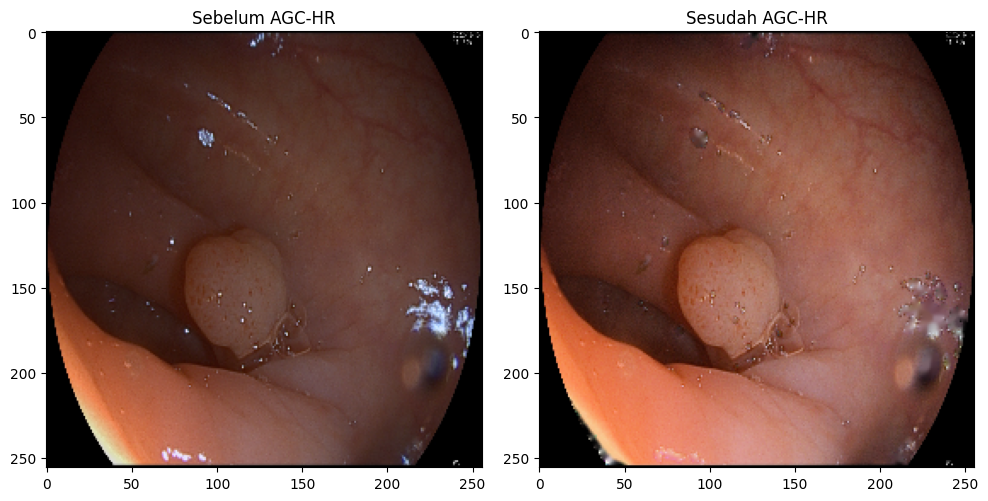

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Baca gambar asli
image_path = '/content/3_polyp (1)_202212150007C125.jpg'  # Ganti dengan path gambar kamu
original_img = cv2.imread(image_path)

# Resize
resized_bgr = cv2.resize(original_img, (256,256))

# Normalisasi ke [0,1]
normalized = resized_bgr.astype('float32') / 255.0

# Untuk AGC, gunakan BGR uint8 kembali
normalized_bgr_u8 = (normalized * 255.0).astype('uint8')

# Perform adaptive gamma correction
output_AGC = adaptive_gamma_correction(normalized_bgr_u8)

# Detect highlights
highlight_mask = adaptive_highlight_detection(output_AGC)

# Repair the highlighted areas
repaired_image_NS = cv2.inpaint(output_AGC, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

# Tampilkan hasil normalisasi
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(normalized_bgr_u8, cv2.COLOR_BGR2RGB))
plt.title("Sebelum AGC-HR")
#plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(repaired_image_NS, cv2.COLOR_BGR2RGB))
plt.title("Sesudah AGC-HR")
#plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
images_path = '/content/kvasir-seg/kvasir-seg/Kvasir-SEG/images'  # Path ke folder yang berisi semua file gambar

# Ambil semua file gambar dari folder
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

output_folder = '/content/output_enhance_kvasir-seg'  # Folder untuk menyimpan hasil
output_enhance = '/content/output_enhance_kvasir-seg/images'  # Folder untuk menyimpan hasil

# Buat folder output jika belum ada
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_enhance, exist_ok=True)

plt.figure(figsize=(10, 8))  # Atur ukuran plot
target_size = (256,256)
for i, img in enumerate(image_files):
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Resize & Konversi gambar ke grayscale
    # resized_image = cv2.resize(input_image, target_size)
    # normalisasi sederhana
    #normal_sed = simple_normalization(input_image)

    # Perform adaptive gamma correction
    output_AGC = adaptive_gamma_correction(input_image)

    # Detect highlights
    highlight_mask = adaptive_highlight_detection(output_AGC)

    # Repair the highlighted areas
    repaired_image_NS = cv2.inpaint(output_AGC, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    # Simpan hasil dengan nama asli
    repaired_path = os.path.join(output_enhance, f'{img}')  # Menambahkan keterangan repaired

    cv2.imwrite(repaired_path, repaired_image_NS)  # Simpan hasil repaired


<Figure size 1000x800 with 0 Axes>

#### Display

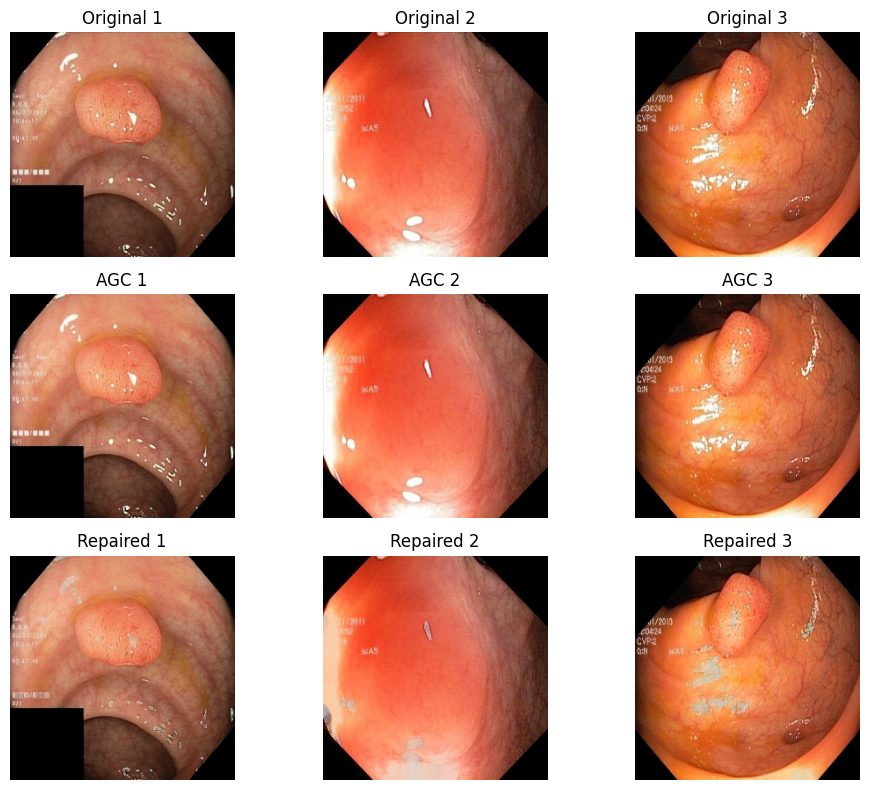

In [ ]:
import random
# Tentukan jumlah gambar yang ingin ditampilkan
num_images = min(len(image_files), 3)  # Batasi tampilan maksimal 10 gambar untuk menghindari masalah plot

plt.figure(figsize=(10, 8))  # Atur ukuran plot
for i, img in enumerate(image_files[:num_images]):
    random.shuffle(image_files)
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Resize & Konversi gambar ke grayscale
    # resized_image = cv2.resize(input_image, target_size)
    # normalisasi sederhana
    #normal_sed = simple_normalization(input_image)

    # Perform adaptive gamma correction
    output_AGC = adaptive_gamma_correction(input_image)

    # Detect highlights
    highlight_mask = adaptive_highlight_detection(output_AGC)

    # Repair the highlighted areas
    repaired_image_NS = cv2.inpaint(output_AGC, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    # Tampilkan hasil pada subplot
    plt.subplot(3, num_images, i + 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(cv2.cvtColor(output_AGC, cv2.COLOR_BGR2RGB))
    plt.title(f'AGC {i+1}')
    plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(cv2.cvtColor(repaired_image_NS, cv2.COLOR_BGR2RGB))
    plt.title(f'Repaired {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil
# Folder input dan output
labels_path="/content/kvasir-seg/kvasir-seg/Kvasir-SEG/bboxes"
output_labels_path="/content/output_enhance_kvasir-seg/bboxes"
# Buat folder output jika belum ada
os.makedirs(output_labels_path, exist_ok=True)


# Salin gambar yang dipilih ke folder output
for image_file in os.listdir(labels_path):
    # Path gambar di folder input
    input_path = os.path.join(labels_path, image_file)

    # Path gambar di folder output
    output_path = os.path.join(output_labels_path, image_file)
    shutil.copy(input_path, output_path)

#### Hapus Folder

In [ ]:
import shutil

# Path folder yang ingin dihapus
folder_path = '/content/output_enhance_rename/bbox'

# Hapus folder beserta isinya
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder {folder_path} telah dihapus.")
else:
    print(f"Folder {folder_path} tidak ditemukan.")


Folder /content/output_enhance_rename/bbox telah dihapus.


#### Download zip

In [ ]:
from google.colab import files
zip_output = '/content/output_enhance_kvasir-seg.zip'  # File ZIP output
output_folder = '/content/output_enhance_kvasir-seg'  # Folder untuk menyimpan hasil
# Kompres folder output menjadi file ZIP

shutil.make_archive(zip_output.replace('.zip', ''), 'zip', output_folder)

files.download(zip_output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SRR - AGC

In [ ]:
images_path = '/content/kvasir-seg/kvasir-seg/Kvasir-SEG/images'  # Path ke folder yang berisi semua file gambar

# Ambil semua file gambar dari folder
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

output_folder = '/content/output_SRR_AGC_kvasir-seg'  # Folder untuk menyimpan hasil
output_enhance = '/content/output_SRR_AGC_kvasir-seg/images'  # Folder untuk menyimpan hasil

# Buat folder output jika belum ada
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_enhance, exist_ok=True)

plt.figure(figsize=(10, 8))  # Atur ukuran plot
target_size = (256,256)
for i, img in enumerate(image_files):
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Resize & Konversi gambar ke grayscale
    # resized_image = cv2.resize(input_image, target_size)
    # normalisasi sederhana
    #normal_sed = simple_normalization(input_image)

    # Detect highlights
    highlight_mask = adaptive_highlight_detection(input_image)

    # Repair the highlighted areas
    repaired_image_NS = cv2.inpaint(input_image, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    # Perform adaptive gamma correction
    output_AGC = adaptive_gamma_correction(repaired_image_NS)

    # Simpan hasil dengan nama asli
    repaired_path = os.path.join(output_enhance, f'{img}')  # Menambahkan keterangan repaired

    cv2.imwrite(repaired_path, output_AGC)  # Simpan hasil repaired


<Figure size 1000x800 with 0 Axes>

#### Display

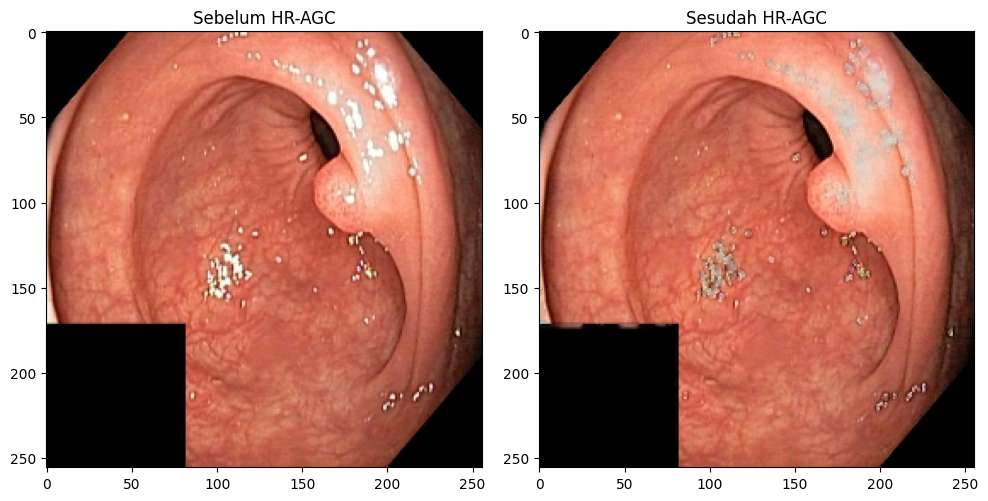

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Baca gambar asli
image_path = '/content/kv-seg-352.jpg'  # Ganti dengan path gambar kamu
original_img = cv2.imread(image_path)

# Resize
resized_bgr = cv2.resize(original_img, (256,256))

# Normalisasi ke [0,1]
normalized = resized_bgr.astype('float32') / 255.0

# Untuk AGC, gunakan BGR uint8 kembali
normalized_bgr_u8 = (normalized * 255.0).astype('uint8')
# Detect highlights
highlight_mask = adaptive_highlight_detection(normalized_bgr_u8)

# Repair the highlighted areas
repaired_image_NS = cv2.inpaint(normalized_bgr_u8, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

# Perform adaptive gamma correction
output_AGC = adaptive_gamma_correction(repaired_image_NS)

# Tampilkan hasil normalisasi
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(normalized_bgr_u8, cv2.COLOR_BGR2RGB))
plt.title("Sebelum HR-AGC")
#plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_AGC, cv2.COLOR_BGR2RGB))
plt.title("Sesudah HR-AGC")
#plt.axis('off')

plt.tight_layout()
plt.show()


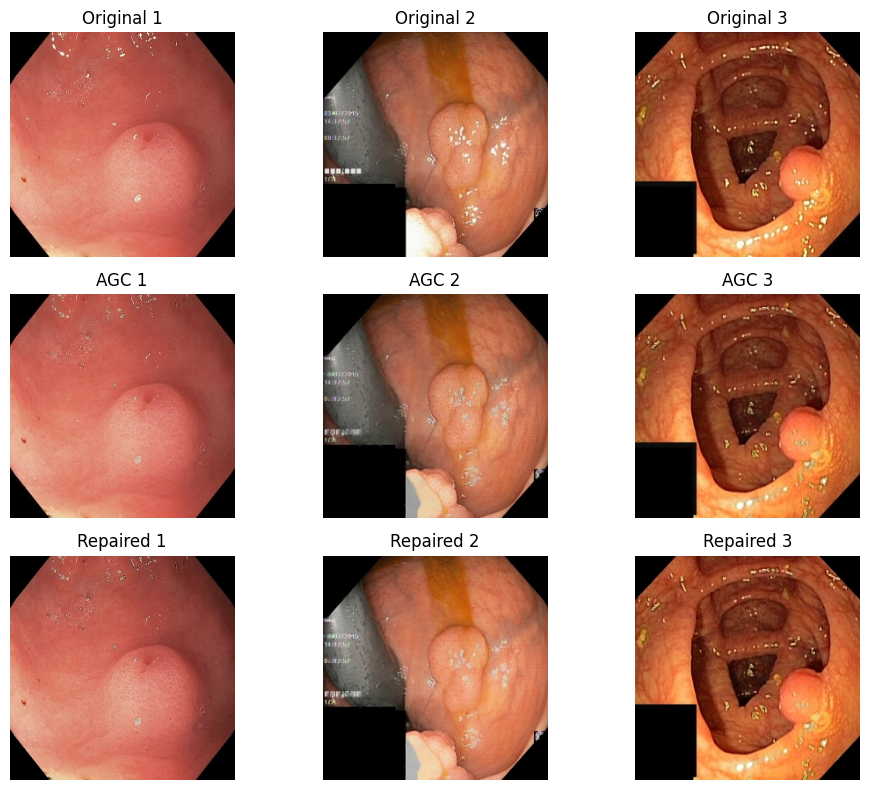

In [ ]:
import random
# Tentukan jumlah gambar yang ingin ditampilkan
num_images = min(len(image_files), 3)  # Batasi tampilan maksimal 10 gambar untuk menghindari masalah plot

plt.figure(figsize=(10, 8))  # Atur ukuran plot
for i, img in enumerate(image_files[:num_images]):
    random.shuffle(image_files)
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Resize & Konversi gambar ke grayscale
    # resized_image = cv2.resize(input_image, target_size)
    # normalisasi sederhana
    #normal_sed = simple_normalization(input_image)

    # Detect highlights
    highlight_mask = adaptive_highlight_detection(input_image)

    # Repair the highlighted areas
    repaired_image_NS = cv2.inpaint(input_image, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    # Perform adaptive gamma correction
    output_AGC = adaptive_gamma_correction(repaired_image_NS)

    # Tampilkan hasil pada subplot
    plt.subplot(3, num_images, i + 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(cv2.cvtColor(repaired_image_NS, cv2.COLOR_BGR2RGB))
    plt.title(f'AGC {i+1}')
    plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(cv2.cvtColor(output_AGC, cv2.COLOR_BGR2RGB))
    plt.title(f'Repaired {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Salin bboxes

In [ ]:
import os
import shutil
# Folder input dan output
labels_path="/content/kvasir-seg/kvasir-seg/Kvasir-SEG/bboxes"
output_labels_path="/content/output_SRR_AGC_kvasir-seg/bboxes"
# Buat folder output jika belum ada
os.makedirs(output_labels_path, exist_ok=True)


# Salin gambar yang dipilih ke folder output
for image_file in os.listdir(labels_path):
    # Path gambar di folder input
    input_path = os.path.join(labels_path, image_file)

    # Path gambar di folder output
    output_path = os.path.join(output_labels_path, image_file)
    shutil.copy(input_path, output_path)

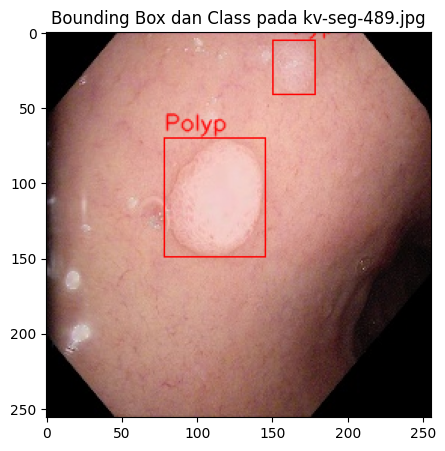

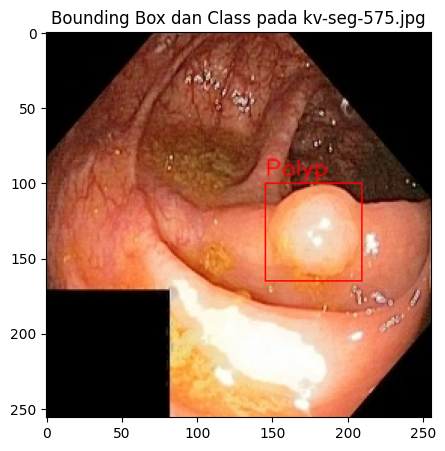

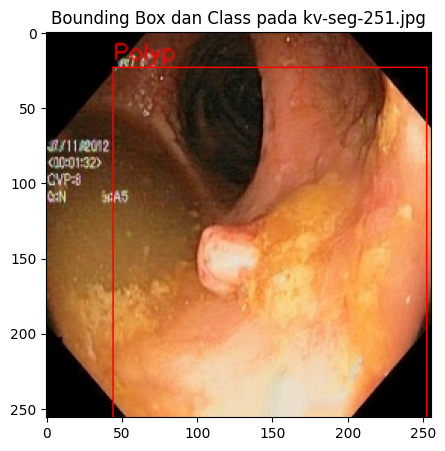

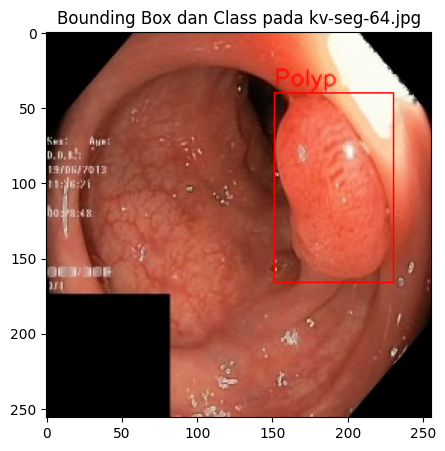

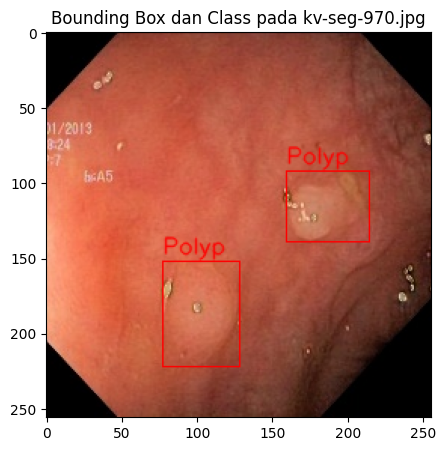

In [ ]:
import cv2
import numpy as np
import os
import random
import glob
import matplotlib.pyplot as plt

#VISUALISASI

def load_bboxes_from_txt(txt_folder):
    """Memuat bounding box dari file TXT dalam format YOLO."""
    bbox_data = {}
    for txt_file in glob.glob(os.path.join(txt_folder, "*.txt")):
        filename = os.path.splitext(os.path.basename(txt_file))[0]
        with open(txt_file, 'r') as f:
            lines = f.readlines()
            bboxes = []
            for line in lines:
                values = line.strip().split()
                if len(values) == 5:
                    class_id, x_center, y_center, w, h = map(float, values)
                    bboxes.append([class_id, x_center, y_center, w, h])
            bbox_data[filename] = bboxes
    return bbox_data

def visualize_bboxes(image_dir, bbox_txt_folder):
    """Memvisualisasikan bounding box dari format TXT pada gambar asli."""
    bbox_data = load_bboxes_from_txt(bbox_txt_folder)

    image_files = os.listdir(image_dir)
    random.shuffle(image_files)  # Acak gambar
    selected_images = image_files[:5]  # Ambil 5 gambar acak

    for image_file in selected_images:
        image_path = os.path.join(image_dir, image_file)
        filename = os.path.splitext(image_file)[0]

        if filename not in bbox_data:
            print(f"Bounding box tidak ditemukan untuk {image_file}, skipping...")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Tidak dapat membaca gambar {image_file}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        for bbox in bbox_data[filename]:
            class_id, x_center, y_center, box_w, box_h = bbox
            x_min = int((x_center - box_w / 2) * w)
            y_min = int((y_center - box_h / 2) * h)
            x_max = int((x_center + box_w / 2) * w)
            y_max = int((y_center + box_h / 2) * h)

            class_name = "Polyp" if int(class_id) == 0 else f"Class {int(class_id)}"
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)
            cv2.putText(image, class_name, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

        plt.figure(figsize=(10, 5))
        plt.imshow(image)
        plt.title(f"Bounding Box dan Class pada {image_file}")
        plt.show()

# Jalankan visualisasi
image_path = '/content/output_SRR_AGC_kvasir-seg/images'
bbox_path = '/content/output_SRR_AGC_kvasir-seg/bboxes'
visualize_bboxes(image_path, bbox_path)

#### Download zip

In [ ]:
from google.colab import files
zip_output = '/content/output_SRR_AGC_kvasir-seg.zip'  # File ZIP output
output_folder = '/content/output_SRR_AGC_kvasir-seg'  # Folder untuk menyimpan hasil
# Kompres folder output menjadi file ZIP

shutil.make_archive(zip_output.replace('.zip', ''), 'zip', output_folder)

files.download(zip_output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
images_path = '/content/data_RSUA/images'  # Path ke folder yang berisi semua file gambar

# Ambil semua file gambar dari folder
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

output_folder_AGC = '/content/output_enhance_AGC_RSUA'  # Folder untuk menyimpan hasil
output_enhance_AGC = '/content/output_enhance_AGC_RSUA/images'  # Folder untuk menyimpan hasil

# Buat folder output jika belum ada
os.makedirs(output_folder_AGC, exist_ok=True)
os.makedirs(output_enhance_AGC, exist_ok=True)

plt.figure(figsize=(10, 8))  # Atur ukuran plot
target_size = (256,256)
for i, img in enumerate(image_files):
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Resize & Konversi gambar ke grayscale
    # resized_image = cv2.resize(input_image, target_size)
    # normalisasi sederhana
    #normal_sed = simple_normalization(input_image)

    # Perform adaptive gamma correction
    output_AGC = adaptive_gamma_correction(input_image)

    # Simpan hasil dengan nama asli
    repaired_path = os.path.join(output_enhance_AGC, f'{img}')  # Menambahkan keterangan repaired

    cv2.imwrite(repaired_path, output_AGC)  # Simpan hasil repaired


<Figure size 1000x800 with 0 Axes>

In [ ]:
images_path = '/content/data_RSUA/images'  # Path ke folder yang berisi semua file gambar

# Ambil semua file gambar dari folder
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

output_folder_AGC = '/content/output_enhance_AGC_RSUA'  # Folder untuk menyimpan hasil
output_enhance_AGC = '/content/output_enhance_AGC_RSUA/images'  # Folder untuk menyimpan hasil

# Buat folder output jika belum ada
os.makedirs(output_folder_AGC, exist_ok=True)
os.makedirs(output_enhance_AGC, exist_ok=True)

plt.figure(figsize=(10, 8))  # Atur ukuran plot
target_size = (256,256)
for i, img in enumerate(image_files):
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Resize & Konversi gambar ke grayscale
    # resized_image = cv2.resize(input_image, target_size)
    # normalisasi sederhana
    #normal_sed = simple_normalization(input_image)

    # Perform adaptive gamma correction
    output_AGC = adaptive_gamma_correction(input_image)

    # Simpan hasil dengan nama asli
    repaired_path = os.path.join(output_enhance_AGC, f'{img}')  # Menambahkan keterangan repaired

    cv2.imwrite(repaired_path, output_AGC)  # Simpan hasil repaired


<Figure size 1000x800 with 0 Axes>

### AGC

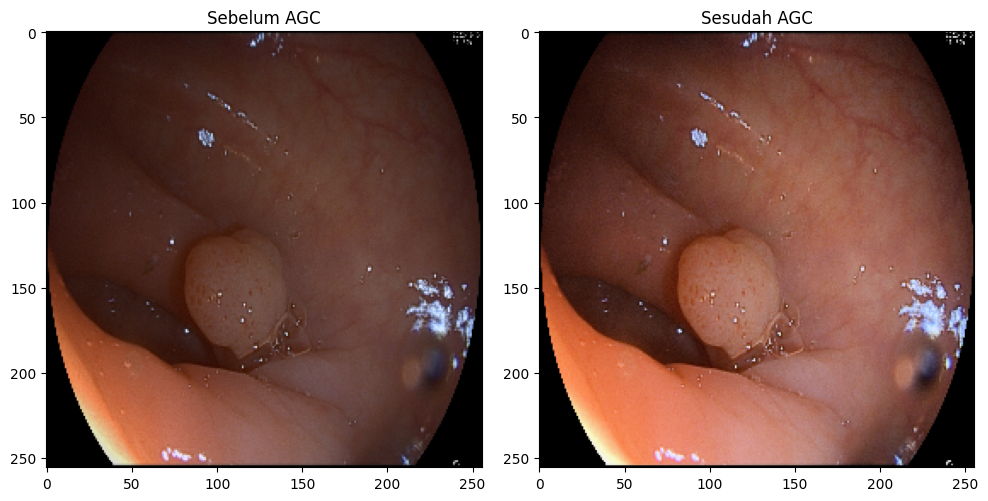

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Baca gambar asli
image_path = '/content/3_polyp (1)_202212150007C125.jpg'  # Ganti dengan path gambar kamu
original_img = cv2.imread(image_path)

# Resize
resized_bgr = cv2.resize(original_img, (256,256))

# Normalisasi ke [0,1]
normalized = resized_bgr.astype('float32') / 255.0

# Untuk AGC, gunakan BGR uint8 kembali
normalized_bgr_u8 = (normalized * 255.0).astype('uint8')
output_AGC = adaptive_gamma_correction(normalized_bgr_u8)

# Tampilkan hasil normalisasi
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(normalized_bgr_u8, cv2.COLOR_BGR2RGB))
plt.title("Sebelum AGC")
#plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_AGC, cv2.COLOR_BGR2RGB))
plt.title("Sesudah AGC")
#plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
images_path = '/content/kvasir-seg/kvasir-seg/Kvasir-SEG/images'  # Path ke folder yang berisi semua file gambar

# Ambil semua file gambar dari folder
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

output_folder_AGC = '/content/output_enhance_AGC_kvasir-seg'  # Folder untuk menyimpan hasil
output_enhance_AGC = '/content/output_enhance_AGC_kvasir-seg/images'  # Folder untuk menyimpan hasil

# Buat folder output jika belum ada
os.makedirs(output_folder_AGC, exist_ok=True)
os.makedirs(output_enhance_AGC, exist_ok=True)

plt.figure(figsize=(10, 8))  # Atur ukuran plot
target_size = (256,256)
for i, img in enumerate(image_files):
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Resize & Konversi gambar ke grayscale
    # resized_image = cv2.resize(input_image, target_size)
    # normalisasi sederhana
    #normal_sed = simple_normalization(input_image)

    # Perform adaptive gamma correction
    output_AGC = adaptive_gamma_correction(input_image)

    # Simpan hasil dengan nama asli
    repaired_path = os.path.join(output_enhance_AGC, f'{img}')  # Menambahkan keterangan repaired

    cv2.imwrite(repaired_path, output_AGC)  # Simpan hasil repaired


<Figure size 1000x800 with 0 Axes>

#### Salin bboxes

In [ ]:
import os
import shutil
# Folder input dan output
labels_path="/content/kvasir-seg/kvasir-seg/Kvasir-SEG/bboxes"
output_labels_path="/content/output_enhance_AGC_kvasir-seg/bboxes"
# Buat folder output jika belum ada
os.makedirs(output_labels_path, exist_ok=True)


# Salin gambar yang dipilih ke folder output
for image_file in os.listdir(labels_path):
    # Path gambar di folder input
    input_path = os.path.join(labels_path, image_file)

    # Path gambar di folder output
    output_path = os.path.join(output_labels_path, image_file)
    shutil.copy(input_path, output_path)

#### Display

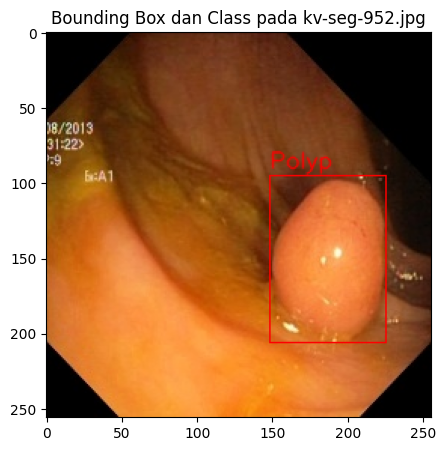

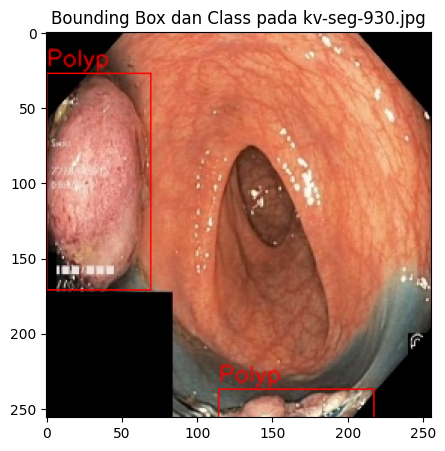

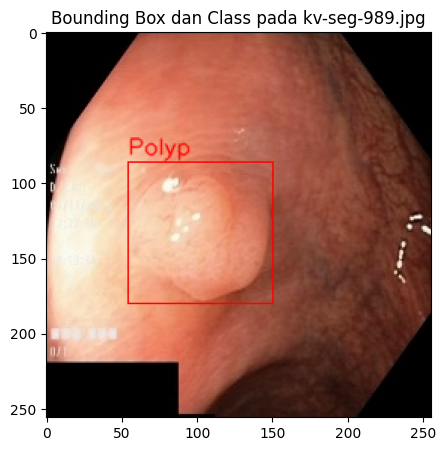

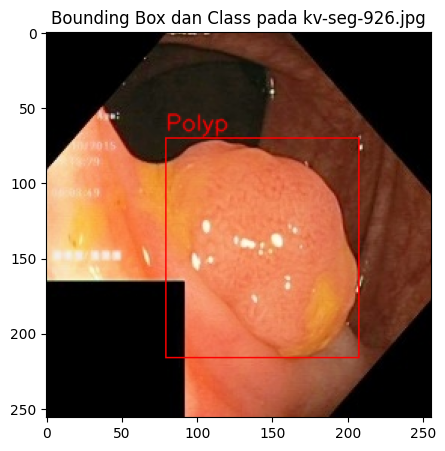

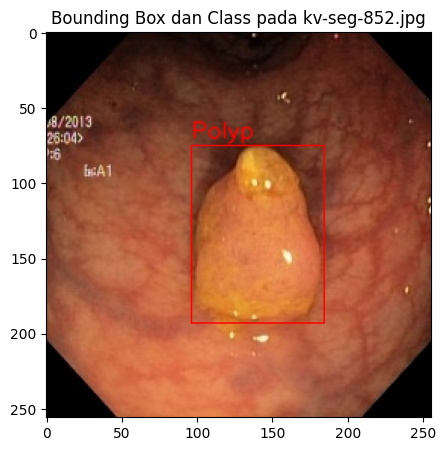

In [ ]:
import cv2
import numpy as np
import os
import random
import glob
import matplotlib.pyplot as plt

#VISUALISASI

def load_bboxes_from_txt(txt_folder):
    """Memuat bounding box dari file TXT dalam format YOLO."""
    bbox_data = {}
    for txt_file in glob.glob(os.path.join(txt_folder, "*.txt")):
        filename = os.path.splitext(os.path.basename(txt_file))[0]
        with open(txt_file, 'r') as f:
            lines = f.readlines()
            bboxes = []
            for line in lines:
                values = line.strip().split()
                if len(values) == 5:
                    class_id, x_center, y_center, w, h = map(float, values)
                    bboxes.append([class_id, x_center, y_center, w, h])
            bbox_data[filename] = bboxes
    return bbox_data

def visualize_bboxes(image_dir, bbox_txt_folder):
    """Memvisualisasikan bounding box dari format TXT pada gambar asli."""
    bbox_data = load_bboxes_from_txt(bbox_txt_folder)

    image_files = os.listdir(image_dir)
    random.shuffle(image_files)  # Acak gambar
    selected_images = image_files[:5]  # Ambil 5 gambar acak

    for image_file in selected_images:
        image_path = os.path.join(image_dir, image_file)
        filename = os.path.splitext(image_file)[0]

        if filename not in bbox_data:
            print(f"Bounding box tidak ditemukan untuk {image_file}, skipping...")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Tidak dapat membaca gambar {image_file}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        for bbox in bbox_data[filename]:
            class_id, x_center, y_center, box_w, box_h = bbox
            x_min = int((x_center - box_w / 2) * w)
            y_min = int((y_center - box_h / 2) * h)
            x_max = int((x_center + box_w / 2) * w)
            y_max = int((y_center + box_h / 2) * h)

            class_name = "Polyp" if int(class_id) == 0 else f"Class {int(class_id)}"
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)
            cv2.putText(image, class_name, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

        plt.figure(figsize=(10, 5))
        plt.imshow(image)
        plt.title(f"Bounding Box dan Class pada {image_file}")
        plt.show()

# Jalankan visualisasi
image_path = '/content/output_enhance_AGC_kvasir-seg/images'
bbox_path = '/content/output_enhance_AGC_kvasir-seg/bboxes'
visualize_bboxes(image_path, bbox_path)

#### Download zip

In [ ]:
from google.colab import files
zip_output = '/content/output_enhance_AGC_kvasir-seg.zip'  # File ZIP output
output_folder = '/content/output_enhance_AGC_kvasir-seg'  # Folder untuk menyimpan hasil
# Kompres folder output menjadi file ZIP

shutil.make_archive(zip_output.replace('.zip', ''), 'zip', output_folder)

files.download(zip_output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SRR

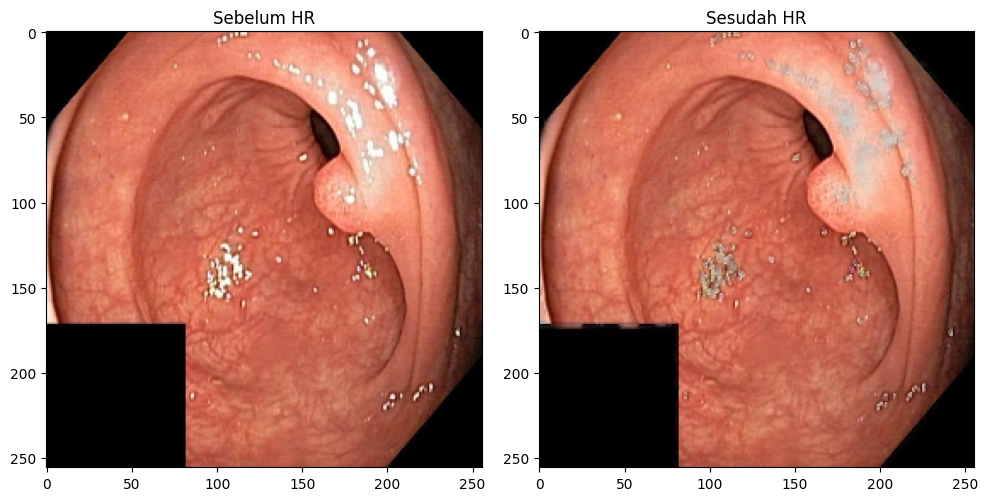

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Baca gambar asli
image_path = '/content/kv-seg-352.jpg'  # Ganti dengan path gambar kamu
original_img = cv2.imread(image_path)

# Resize
resized_bgr = cv2.resize(original_img, (256,256))

# Normalisasi ke [0,1]
normalized = resized_bgr.astype('float32') / 255.0

# Untuk AGC, gunakan BGR uint8 kembali
normalized_bgr_u8 = (normalized * 255.0).astype('uint8')
# Detect highlights
highlight_mask = adaptive_highlight_detection(normalized_bgr_u8)

# Repair the highlighted areas
repaired_image_NS = cv2.inpaint(normalized_bgr_u8, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

# Tampilkan hasil normalisasi
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(normalized_bgr_u8, cv2.COLOR_BGR2RGB))
plt.title("Sebelum HR")
#plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(repaired_image_NS, cv2.COLOR_BGR2RGB))
plt.title("Sesudah HR")
#plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
images_path = '/content/kvasir-seg/kvasir-seg/Kvasir-SEG/images'  # Path ke folder yang berisi semua file gambar

# Ambil semua file gambar dari folder
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

output_folder_SRR = '/content/output_enhance_SRR_kvasir-seg'  # Folder untuk menyimpan hasil
output_enhance_SRR = '/content/output_enhance_SRR_kvasir-seg/images'  # Folder untuk menyimpan hasil

# Buat folder output jika belum ada
os.makedirs(output_folder_SRR, exist_ok=True)
os.makedirs(output_enhance_SRR, exist_ok=True)

plt.figure(figsize=(10, 8))  # Atur ukuran plot

for i, img in enumerate(image_files):
    img_path = os.path.join(images_path, img)

    # Load an image
    input_image = cv2.imread(img_path)

    # Detect highlights
    highlight_mask = adaptive_highlight_detection(input_image)

    # Repair the highlighted areas
    repaired_image_NS = cv2.inpaint(input_image, highlight_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    # Simpan hasil dengan nama asli
    repaired_path = os.path.join(output_enhance_SRR, f'{img}')  # Menambahkan keterangan repaired

    cv2.imwrite(repaired_path, repaired_image_NS)  # Simpan hasil repaired


<Figure size 1000x800 with 0 Axes>

#### Salin bboxes

In [ ]:
import os
import shutil
# Folder input dan output
labels_path="/content/kvasir-seg/kvasir-seg/Kvasir-SEG/bboxes"
output_labels_path="/content/output_enhance_SRR_kvasir-seg/bboxes"
# Buat folder output jika belum ada
os.makedirs(output_labels_path, exist_ok=True)


# Salin gambar yang dipilih ke folder output
for image_file in os.listdir(labels_path):
    # Path gambar di folder input
    input_path = os.path.join(labels_path, image_file)

    # Path gambar di folder output
    output_path = os.path.join(output_labels_path, image_file)
    shutil.copy(input_path, output_path)

#### Display

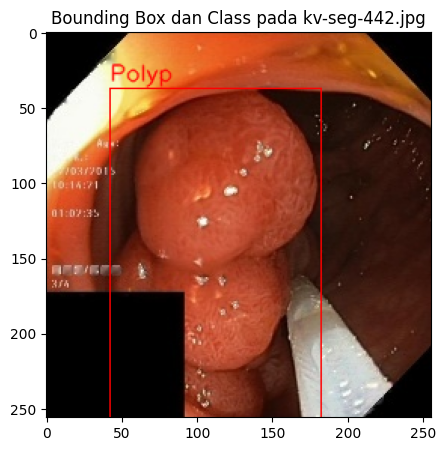

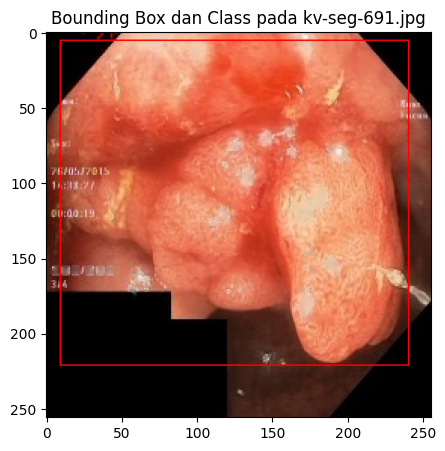

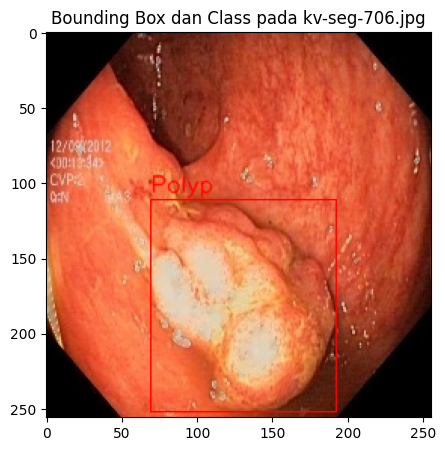

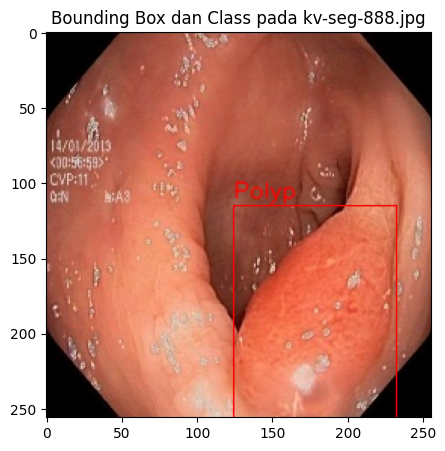

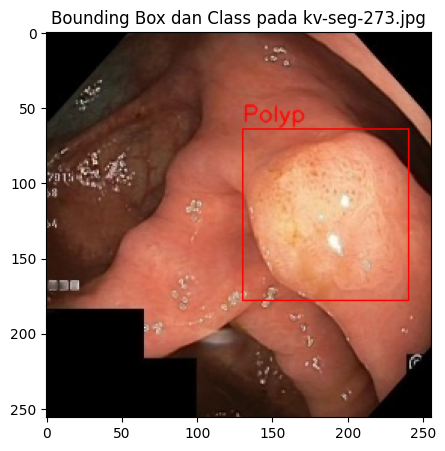

In [ ]:
import cv2
import numpy as np
import os
import random
import glob
import matplotlib.pyplot as plt

#VISUALISASI

def load_bboxes_from_txt(txt_folder):
    """Memuat bounding box dari file TXT dalam format YOLO."""
    bbox_data = {}
    for txt_file in glob.glob(os.path.join(txt_folder, "*.txt")):
        filename = os.path.splitext(os.path.basename(txt_file))[0]
        with open(txt_file, 'r') as f:
            lines = f.readlines()
            bboxes = []
            for line in lines:
                values = line.strip().split()
                if len(values) == 5:
                    class_id, x_center, y_center, w, h = map(float, values)
                    bboxes.append([class_id, x_center, y_center, w, h])
            bbox_data[filename] = bboxes
    return bbox_data

def visualize_bboxes(image_dir, bbox_txt_folder):
    """Memvisualisasikan bounding box dari format TXT pada gambar asli."""
    bbox_data = load_bboxes_from_txt(bbox_txt_folder)

    image_files = os.listdir(image_dir)
    random.shuffle(image_files)  # Acak gambar
    selected_images = image_files[:5]  # Ambil 5 gambar acak

    for image_file in selected_images:
        image_path = os.path.join(image_dir, image_file)
        filename = os.path.splitext(image_file)[0]

        if filename not in bbox_data:
            print(f"Bounding box tidak ditemukan untuk {image_file}, skipping...")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Tidak dapat membaca gambar {image_file}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        for bbox in bbox_data[filename]:
            class_id, x_center, y_center, box_w, box_h = bbox
            x_min = int((x_center - box_w / 2) * w)
            y_min = int((y_center - box_h / 2) * h)
            x_max = int((x_center + box_w / 2) * w)
            y_max = int((y_center + box_h / 2) * h)

            class_name = "Polyp" if int(class_id) == 0 else f"Class {int(class_id)}"
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)
            cv2.putText(image, class_name, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

        plt.figure(figsize=(10, 5))
        plt.imshow(image)
        plt.title(f"Bounding Box dan Class pada {image_file}")
        plt.show()

# Jalankan visualisasi
image_path = '/content/output_enhance_SRR_kvasir-seg/images'
bbox_path = '/content/output_enhance_SRR_kvasir-seg/bboxes'
visualize_bboxes(image_path, bbox_path)

#### Download zip

In [ ]:
from google.colab import files
zip_output = '/content/output_enhance_SRR_kvasir-seg.zip'  # File ZIP output
output_folder = '/content/output_enhance_SRR_kvasir-seg'  # Folder untuk menyimpan hasil
# Kompres folder output menjadi file ZIP

shutil.make_archive(zip_output.replace('.zip', ''), 'zip', output_folder)

files.download(zip_output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##display skrip

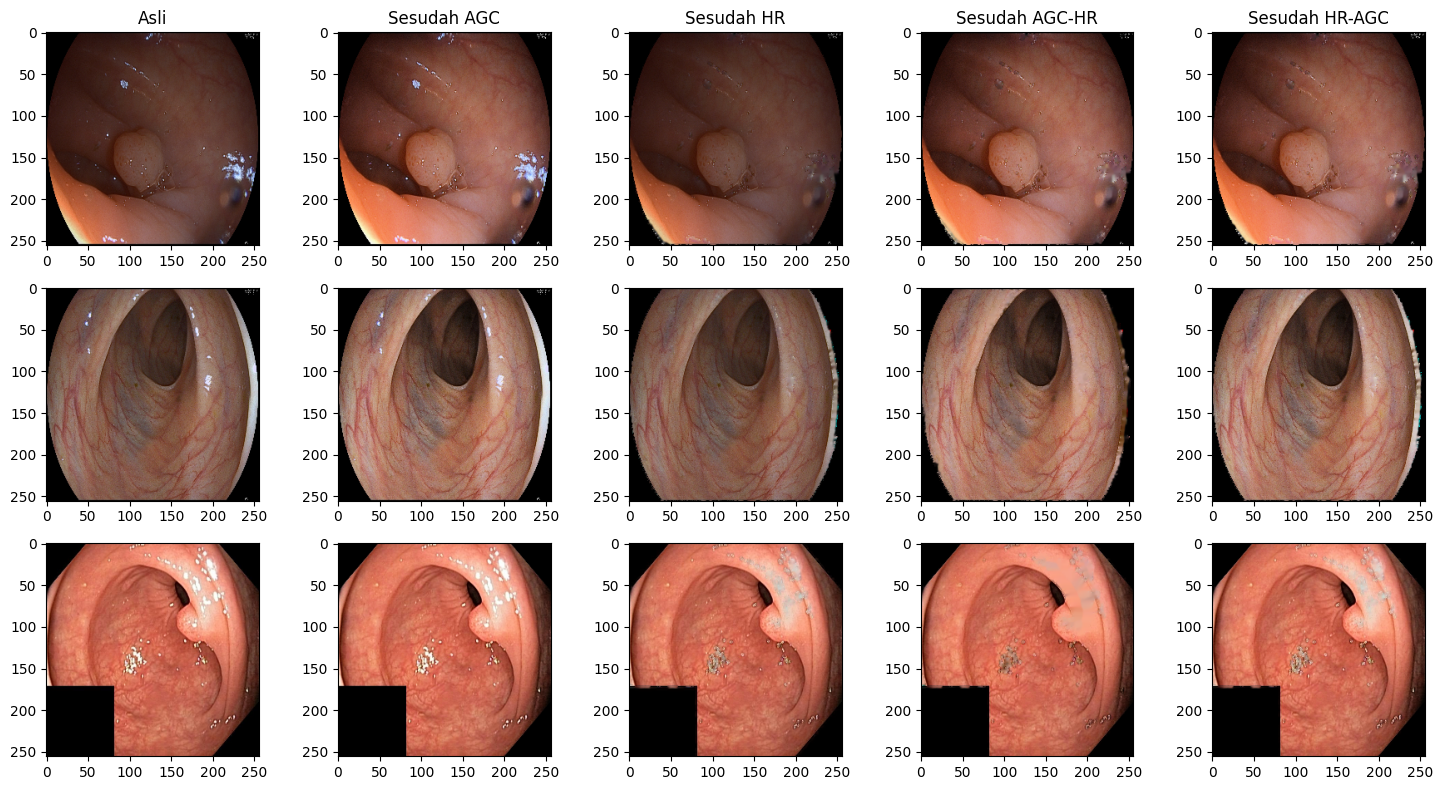

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Baca gambar asli
image_path_prs = '/content/3_polyp (1)_202212150007C125.jpg'  # Ganti dengan path gambar kamu
original_img_prs = cv2.imread(image_path_prs)

image_path_nrs = '/content/202212150007C042.jpg'  # Ganti dengan path gambar kamu
original_img_nrs = cv2.imread(image_path_nrs)

image_path_kv = '/content/kv-seg-352.jpg'  # Ganti dengan path gambar kamu
original_img_kv = cv2.imread(image_path_kv)

# Resize
resized_bgr_prs = cv2.resize(original_img_prs, (256,256))
resized_bgr_nrs = cv2.resize(original_img_nrs, (256,256))
resized_bgr_kv = cv2.resize(original_img_kv, (256,256))

# Normalisasi ke [0,1]
normalized_prs = resized_bgr_prs.astype('float32') / 255.0
normalized_nrs = resized_bgr_nrs.astype('float32') / 255.0
normalized_kv = resized_bgr_kv.astype('float32') / 255.0

# Untuk AGC, gunakan BGR uint8 kembali
normalized_bgr_u8_prs = (normalized_prs * 255.0).astype('uint8')
normalized_bgr_u8_nrs = (normalized_nrs * 255.0).astype('uint8')
normalized_bgr_u8_kv = (normalized_kv * 255.0).astype('uint8')

# Perform adaptive gamma correction
output_AGC_prs1 = adaptive_gamma_correction(normalized_bgr_u8_prs)
output_AGC_nrs1 = adaptive_gamma_correction(normalized_bgr_u8_nrs)
output_AGC_kv1 = adaptive_gamma_correction(normalized_bgr_u8_kv)

# Detect highlights
highlight_mask_prs1 = adaptive_highlight_detection(normalized_bgr_u8_prs)
highlight_mask_nrs1 = adaptive_highlight_detection(normalized_bgr_u8_nrs)
highlight_mask_kv1 = adaptive_highlight_detection(normalized_bgr_u8_kv)

# Repair the highlighted areas
repaired_image_NS_prs1 = cv2.inpaint(normalized_bgr_u8_prs, highlight_mask_prs1, inpaintRadius=3, flags=cv2.INPAINT_NS)
repaired_image_NS_nrs1 = cv2.inpaint(normalized_bgr_u8_nrs, highlight_mask_nrs1, inpaintRadius=3, flags=cv2.INPAINT_NS)
repaired_image_NS_kv1 = cv2.inpaint(normalized_bgr_u8_kv, highlight_mask_kv1, inpaintRadius=3, flags=cv2.INPAINT_NS)

# Perform adaptive gamma correction
output_AGC_prs = adaptive_gamma_correction(repaired_image_NS_prs1)
output_AGC_nrs = adaptive_gamma_correction(repaired_image_NS_nrs1)
output_AGC_kv = adaptive_gamma_correction(repaired_image_NS_kv1)

# Detect highlights
highlight_mask_prs = adaptive_highlight_detection(output_AGC_prs)
highlight_mask_nrs = adaptive_highlight_detection(output_AGC_nrs)
highlight_mask_kv = adaptive_highlight_detection(output_AGC_kv)

# Repair the highlighted areas
repaired_image_NS_prs = cv2.inpaint(output_AGC_prs, highlight_mask_prs, inpaintRadius=3, flags=cv2.INPAINT_NS)
repaired_image_NS_nrs = cv2.inpaint(output_AGC_nrs, highlight_mask_nrs, inpaintRadius=3, flags=cv2.INPAINT_NS)
repaired_image_NS_kv = cv2.inpaint(output_AGC_kv, highlight_mask_kv, inpaintRadius=3, flags=cv2.INPAINT_NS)

# Tampilkan hasil normalisasi
plt.figure(figsize=(15, 8))

plt.subplot(3, 5, 1)
plt.imshow(cv2.cvtColor(normalized_bgr_u8_prs, cv2.COLOR_BGR2RGB))
plt.title("Asli")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 2)
plt.imshow(cv2.cvtColor(output_AGC_prs1, cv2.COLOR_BGR2RGB))
plt.title("Sesudah AGC")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 3)
plt.imshow(cv2.cvtColor(repaired_image_NS_prs1, cv2.COLOR_BGR2RGB))
plt.title("Sesudah HR")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 4)
plt.imshow(cv2.cvtColor(repaired_image_NS_prs, cv2.COLOR_BGR2RGB))
plt.title("Sesudah AGC-HR")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 5)
plt.imshow(cv2.cvtColor(output_AGC_prs, cv2.COLOR_BGR2RGB))
plt.title("Sesudah HR-AGC")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 6)
plt.imshow(cv2.cvtColor(normalized_bgr_u8_nrs, cv2.COLOR_BGR2RGB))
#plt.title("Aslii")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 7)
plt.imshow(cv2.cvtColor(output_AGC_nrs1, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah AGC")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 8)
plt.imshow(cv2.cvtColor(repaired_image_NS_nrs1, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah HR")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 9)
plt.imshow(cv2.cvtColor(repaired_image_NS_nrs, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah AGC-HR")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 10)
plt.imshow(cv2.cvtColor(output_AGC_nrs, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah HR-AGC")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 11)
plt.imshow(cv2.cvtColor(normalized_bgr_u8_kv, cv2.COLOR_BGR2RGB))
#plt.title("Asli")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 12)
plt.imshow(cv2.cvtColor(output_AGC_kv1, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah AGC")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 13)
plt.imshow(cv2.cvtColor(repaired_image_NS_kv1, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah HR")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 14)
plt.imshow(cv2.cvtColor(repaired_image_NS_kv, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah AGC-HR")
plt.xticks(ticks=range(0, 256, 50))

plt.subplot(3, 5, 15)
plt.imshow(cv2.cvtColor(output_AGC_kv, cv2.COLOR_BGR2RGB))
#plt.title("Sesudah HR-AGC")
plt.xticks(ticks=range(0, 256, 50))

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.05)
plt.show()
